# 06 — Compare: algoritmusok összegzése
Források: `results/tables/kmeans_kmedoids.csv`, `agglomerative.csv`, `dbscan.csv`, (opció: `fcm.csv`)
- Mutatjuk: a **legjobb silhouette** értéket dataset × módszer bontásban (heatmap).
- Kiegészítés: átlagos **DB** és **CH** táblák, opcionális futásidő-összegzés.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


project_root = os.path.abspath("..")
tables_dir = os.path.join(project_root, "results", "tables")

files = ["kmeans_kmedoids.csv", "agglomerative.csv", "dbscan.csv", "fcm.csv"]
dfs = []
for f in files:
    p = os.path.join(tables_dir, f)
    if os.path.exists(p):
        df = pd.read_csv(p)
        df["source"] = f.replace(".csv","")
        dfs.append(df)

if not dfs:
    raise SystemExit("Nincs beolvasható eredmény (.csv). Futtasd a 02/03/04 (és ha kell 05) notebookokat.")

raw = pd.concat(dfs, ignore_index=True)
raw.head()


,dataset,algo,k,sil,db,ch,source,linkage,eps,min_samples,m
0,blobs,kmeans,4.0,0.755672,0.339428,5937.966481,kmeans_kmedoids,NaN,NaN,NaN,NaN
1,blobs,kmedoids,4.0,0.581410,0.787534,1712.667532,kmeans_kmedoids,NaN,NaN,NaN,NaN
2,moons,kmeans,2.0,0.494269,0.810828,1111.567362,kmeans_kmedoids,NaN,NaN,NaN,NaN
3,moons,kmedoids,2.0,0.485252,0.818195,1061.468037,kmeans_kmedoids,NaN,NaN,NaN,NaN
4,circles,kmeans,2.0,0.352557,1.186661,457.337747,kmeans_kmedoids,NaN,NaN,NaN,NaN


In [2]:
def method_label(row):
    if "algo" in row and isinstance(row["algo"], str):
        return row["algo"]
    if "linkage" in row and isinstance(row["linkage"], str):
        return f"agglo-{row['linkage']}"
    if "eps" in row:  # DBSCAN táblákban
        return "dbscan"
    return "unknown"

raw["method"] = raw.apply(method_label, axis=1)
# kulcs metrikák nálad: sil, db, ch
raw_cols = ["dataset", "method", "sil", "db", "ch"]
raw[raw_cols].head()


,dataset,method,sil,db,ch
0,blobs,kmeans,0.755672,0.339428,5937.966481
1,blobs,kmedoids,0.581410,0.787534,1712.667532
2,moons,kmeans,0.494269,0.810828,1111.567362
3,moons,kmedoids,0.485252,0.818195,1061.468037
4,circles,kmeans,0.352557,1.186661,457.337747


In [3]:
best = (
    raw.dropna(subset=["sil"])
       .sort_values("sil", ascending=False)
       .groupby(["dataset","method"], as_index=False)
       .first()[["dataset","method","sil","db","ch"]]
)
best.sort_values(["dataset","sil"], ascending=[True, False]).head(20)


,dataset,method,sil,db,ch
1,blobs,agglo-complete,0.755672,0.339428,5937.966481
3,blobs,agglo-ward,0.755672,0.339428,5937.966481
5,blobs,fcm,0.755672,0.339428,5937.966481
6,blobs,kmeans,0.755672,0.339428,5937.966481
0,blobs,agglo-average,0.755193,0.339845,5924.924914
2,blobs,agglo-single,0.603003,0.386475,1663.516477
7,blobs,kmedoids,0.581410,0.787534,1712.667532
4,blobs,dbscan,0.522905,1.474741,1197.181653
14,circles,kmeans,0.352557,1.186661,457.337747
15,circles,kmedoids,0.352013,1.187685,455.687500


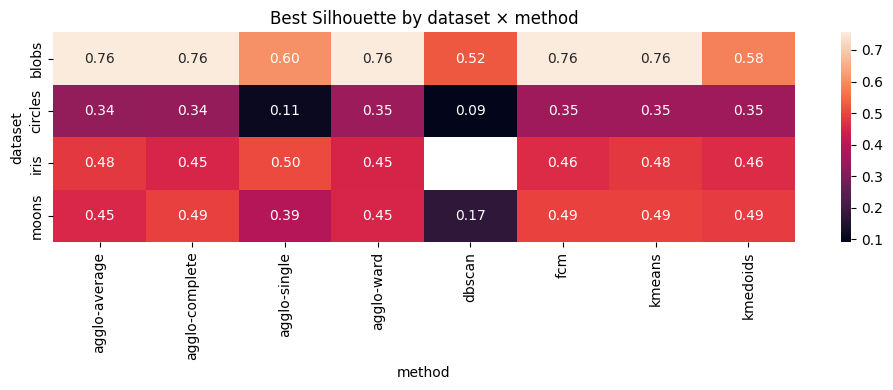

In [4]:
pivot_sil = best.pivot_table(index="dataset", columns="method", values="sil")
plt.figure(figsize=(10,4))
sns.heatmap(pivot_sil, annot=True, fmt=".2f")
plt.title("Best Silhouette by dataset × method")
plt.tight_layout(); plt.show()


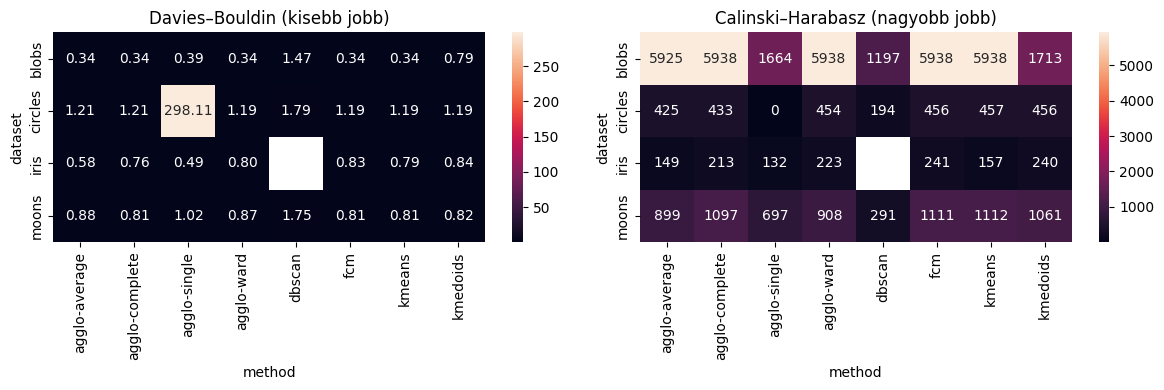

In [5]:
pivot_db = best.pivot_table(index="dataset", columns="method", values="db")
pivot_ch = best.pivot_table(index="dataset", columns="method", values="ch")

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(pivot_db, annot=True, fmt=".2f", ax=ax[0])
ax[0].set_title("Davies–Bouldin (kisebb jobb)")
sns.heatmap(pivot_ch, annot=True, fmt=".0f", ax=ax[1])
ax[1].set_title("Calinski–Harabasz (nagyobb jobb)")
fig.tight_layout(); plt.show()


In [6]:
out = best.sort_values(["dataset","sil"], ascending=[True, False])
out_path = os.path.join(tables_dir, "compare_best.csv")
out.to_csv(out_path, index=False)
print("Mentve:", out_path)
out


Mentve: /Users/adombence/Projects/clustering-playground/results/tables/compare_best.csv


,dataset,method,sil,db,ch
1,blobs,agglo-complete,0.755672,0.339428,5937.966481
3,blobs,agglo-ward,0.755672,0.339428,5937.966481
5,blobs,fcm,0.755672,0.339428,5937.966481
6,blobs,kmeans,0.755672,0.339428,5937.966481
0,blobs,agglo-average,0.755193,0.339845,5924.924914
2,blobs,agglo-single,0.603003,0.386475,1663.516477
7,blobs,kmedoids,0.581410,0.787534,1712.667532
4,blobs,dbscan,0.522905,1.474741,1197.181653
14,circles,kmeans,0.352557,1.186661,457.337747
15,circles,kmedoids,0.352013,1.187685,455.687500


## 🏆 Összefoglaló: Nyertes algoritmusok

Az alábbi táblázatok megmutatják, melyik algoritmus működött a legjobban az egyes dataset-eken, valamint az általános átlagos teljesítményt.

In [7]:
# Legjobb algoritmus minden dataset-hez (silhouette alapján)
winners = best.loc[best.groupby("dataset")["sil"].idxmax()]
print("\n🏆 Nyertes módszer dataset-enként (legnagyobb silhouette):\n")
display(winners[["dataset", "method", "sil", "db", "ch"]].sort_values("sil", ascending=False))

print("\n" + "="*60 + "\n")

# Általános rangsor: átlagos teljesítmény módszerenként
method_avg = best.groupby("method")[["sil", "db", "ch"]].mean().sort_values("sil", ascending=False)
print("📊 Átlagos teljesítmény módszerenként:\n")
display(method_avg)


🏆 Nyertes módszer dataset-enként (legnagyobb silhouette):



,dataset,method,sil,db,ch
1,blobs,agglo-complete,0.755672,0.339428,5937.966481
18,iris,agglo-single,0.504646,0.492925,131.535896
28,moons,fcm,0.494390,0.810730,1110.744872
14,circles,kmeans,0.352557,1.186661,457.337747




📊 Átlagos teljesítmény módszerenként:



,sil,db,ch
method,,,
kmeans,0.520595,0.781570,1916.057936
fcm,0.515103,0.793113,1936.590259
agglo-complete,0.509210,0.780479,1920.239329
agglo-average,0.505744,0.751475,1849.388034
agglo-ward,0.500349,0.800083,1880.702595
kmedoids,0.469429,0.907967,867.392834
agglo-single,0.402071,75.002704,623.082347
dbscan,0.263280,1.671563,560.581406
